# Material Balances XIII

This lecture introduces reactor design for systems involving multiple reactions. As you work through this notebook, pay attention to the differences in how we approach reactor design problems for systems involving more than one reaction (compared to the problems so far, which always involved only one reaction). If you are comfortable with numerical methods by this point in the course, you should find only one major difference in how we set up and solve these problems. We'll also have to talk about things like selectivity and yield, but the mechanics of solving these problems is not very different from what we've already learned.

```{important}
The only real, fundamental difference we will see when design reactors in cases where there are multiple reactions is that we will have to account for multiple reaction rates when we define the production rate of species $j$:

$$R_j = \sum_i \nu_{i,j}r_i$$

The rest will be slight differences in how we solve the problems -- mostly that analytical solutions will be harder, and we will usually need to use numerical methods.
```

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

(example-problem-01)=
## Example Problem 01

```{note}
This is Example 4.5 from *Chemical Reactor Analysis and Design Fundamentals, 2nd ed.* by Rawlings and Ekerdt.
```

You are carrying out Benzene Pyrolysis in a Plug Flow Reactor operating at 1033K and 1.0 atm.  The two reactions occurring in this system are (1) benzene coupling to form diphenyl and hydrogen followed by (2) a secondary reaction between benzene and diphenyl to form triphenyl and hydrogen:

\begin{align*}
2B &\longleftrightarrow D + H_2\\
B + D &\longleftrightarrow T + H_2
\end{align*}

Both reactions are reversible and ***follow elementary rate laws***.  Rate constants and equilibrium concentration ratios ($K_C$) are given below.

\begin{align*}
k_1 &= 7.0 \ \times 10^5 \ \textrm{L} \ \textrm{mol}^{-1} \ \textrm{h}^{-1}\\
k_2 &= 4.0 \ \times 10^5 \ \textrm{L} \ \textrm{mol}^{-1} \ \textrm{h}^{-1}\\
K_{C_1} &= 0.31\\
K_{C_2} &= 0.48
\end{align*}

1. If pure benzene is fed into the reactor at 60,000 moles per hour, find the PFR volume required to achieve 50\% conversion of Benzene.
2. Plot the mole fraction of each species as a function of PFR volume.

**Answer**: $V = 403.3\mathrm{L}$

### Solution to Example Problem 01

Even though there are multiple reactions, we approach this problem the same way that we typically do: we have been asked to determine the reactor size required to achieve a certain conversion of Benzene. This prompts us to write a material balance on Benzene in a PFR operating at steady state:

$$\frac{dF_B}{dV} = R_B$$

$R_B$ is going to be a complex function of concentrations of all of the species present in this system. We say this because:

$$R_B = \sum_i \nu_{i,B} r_i$$

We can substitute stoichiometric coefficients for B in each reaction to find:

$$R_B = -2r_1 - r_2$$

We have two reactions, each with a unique rate expression:

\begin{align}
    r_1 &= k_{1,f}C_B^2 - k_{1,r}C_HC_D \\
    r_2 &= k_{2,f}C_BC_D - k_{2,r}C_HC_T \\
\end{align}

Examining these rate laws, we see that calculating $r_1$ and $r_2$ requires that we know concentrations for all species. That means we can't solve the above balance on Benzene until we have either (1) defined each concentration in terms of the same state variable or (2) write balances on each species to create a coupled system of ODEs wherein we have a unique state variable corresponding to each species. As before, when we have coupled systems of ODEs, we solve them all simultaneously using an ODE solver. We write a material balance on each species:

\begin{align}
    \frac{dF_B}{dV} &= R_B \\
    \frac{dF_D}{dV} &= R_D \\
    \frac{dF_H}{dV} &= R_H \\
    \frac{dF_T}{dV} &= R_T \\
\end{align}

We now have 4 ordinary differential equations that tell us how 4 state dependent variables ($F_B$, $F_D$, $F_H$, $F_T$) change as a function of the one independent variable, $V$. We can solve this system *if* we can define everything on the right hand sides of the above equations ($R_B$, $R_D$, $R_H$, and $R_T$) in terms of (1) constants, (2) our state variables ($F_B$, $F_D$, $F_H$, $F_T$), and/or (3) $V$.

We know how to do this!!

Generally:

$$R_j = \sum_i \nu_{i,j} r_i$$

So:

\begin{align}
    R_B &= -2r_1 - r_2 \\
    R_D &=  r_1 - r_2 \\
    R_H &=  r_1 + r_2 \\
    R_T &=  r_2 \\
\end{align}

We have already defined reaction rates:

\begin{align}
    r_1 &= k_{1,f}C_B^2 - k_{1,r}C_HC_D \\
    r_2 &= k_{2,f}C_BC_D - k_{2,r}C_HC_T \\
\end{align}

And we can define concentrations in terms of molar flowrates:

$$C_j = \frac{F_j}{Q}$$

This adds a volumetric flowrate, $Q$, into the mix. Fortunately, this is a gas phase reaction at low pressure, so we can define $Q$ in terms of the total molar flowrate:

$$Q = \frac{F_{tot}RT}{P}$$

Where

$$F_{tot} = \sum_j F_j$$

With that, we've defined our system of ODES fully as a function of molar flowrates and reactor volume. We can solve this numerically using `solve_ivp()`.  This is done in the code cell below.

The Volume required to achive 50% Benzene conversion is 403.3L


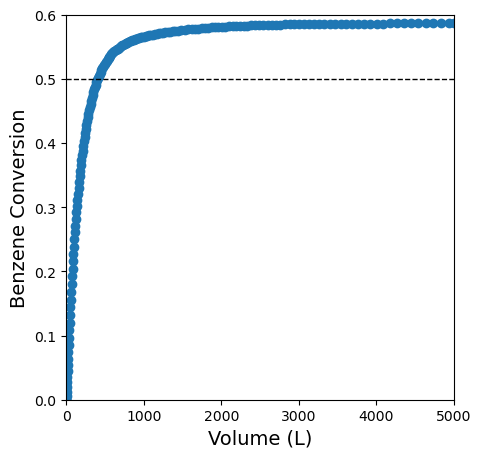

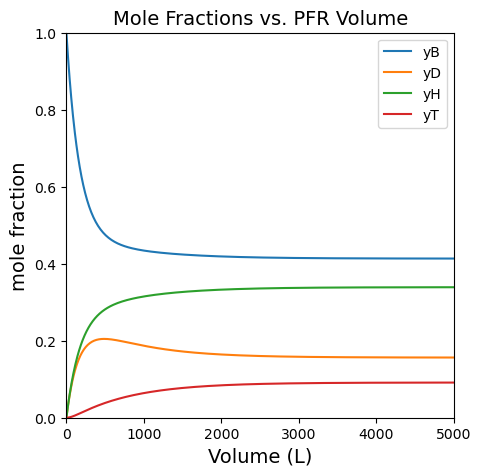

In [11]:
#############################################################
# Constants from problem statement; define as globals       #
#############################################################

T   = 1033    #K
P   = 1.0     #atm
R   = 0.08206 #L*atm/mol/K
k1f = 7.0e5   #L/mol/h
k2f = 4.0e5   #L/mol/h
KC1 = 0.31
KC2 = 0.48
k1r = k1f/KC1 #L/mol/h
k2r = k2f/KC2 #L/mol/h
FBf = 60000   #mol/h
FDf = 0
FHf = 0
FTf = 0

##############################################################
# Define ODE system in a function                            #
# Function has typical form f(V, [FB, FD, FH, FT])           #
# It returns [dFB/dV, dFD/dV, dFH/dV, dFT/dV]                #
##############################################################

def P01(vol, var):
    
    #unpack state-dependent variables in var
    FB, FD, FH, FT = var
    
    # The above is functionally equivalent to
    # FB = var[0]
    # FD = var[1]
    # FH = var[2]
    # FT = var[3]
      
    #total molar flowrate, function of individual molar flowrates
    FTOT = FB + FD + FH + FT
    
    #volumetric flowrate
    Q    = FTOT*R*T/P
    
    #Define concentrations
    CB   = FB/Q
    CD   = FD/Q
    CH   = FH/Q
    CT   = FT/Q
    
    #now that we have concentrations, we define reaction rates
    r1   = k1f*CB**2 - k1r*CD*CH
    r2   = k2f*CB*CD - k2r*CT*CH
    
    #With reaction rates, you can define production rates
    RB   = -2*r1 - r2
    RD   =    r1 - r2
    RH   =    r1 + r2
    RT   =         r2
    
    #For a PFR, dFj/dV = Rj, so these are our derivatives of FB, FD, FH, FT
    D1   = RB
    D2   = RD
    D3   = RH
    D4   = RT
    
    #return derivatives of each dependent variable w.r.t. volume
    return [D1, D2, D3, D4]

############################################################################
# Set starting state and integration span for solve_ivp()                  #
############################################################################
vspan   = (0, 5000)
var0    = [FBf, FDf, FHf, FTf]

############################################################################
# Solve using solve_ivp()                                                  #
############################################################################
solP01 = solve_ivp(P01, vspan, var0, atol = 1e-10, rtol = 1e-10)

############################################################################
# Extract necessary data from the solution structure.                      #
############################################################################
Vout    = solP01.t
FBout   = solP01.y[0]
FDout   = solP01.y[1]
FHout   = solP01.y[2]
FTout   = solP01.y[3]
FTot_o  = FBout + FDout + FHout + FTout

############################################################################
# Calculate fractional conversion of benzene                               #
############################################################################
XBout   = (FBf - FBout)/FBf

############################################################################
# Calculate species mole fractions                                         #
############################################################################
yBout   = FBout/FTot_o
yDout   = FDout/FTot_o
yHout   = FHout/FTot_o
yTout   = FTout/FTot_o

############################################################################
# Create an interpolating polynomial f(XB) = V; print f(0.5)               #
############################################################################
itp01   = interp1d(XBout, Vout, kind = 'cubic')
print(f'The Volume required to achive 50% Benzene conversion is {itp01(0.5):3.1f}L')

############################################################################
# Plot benzene conversion vs. reactor volume                               #
############################################################################
plt.figure(figsize = (5, 5))
plt.scatter(Vout, XBout)
plt.xlim(0, max(vspan))
plt.ylim(0, 0.6)
plt.hlines(0.5, 0, max(vspan), linestyle = 'dashed', color = 'black', linewidth = 1)
plt.xlabel('Volume (L)', fontsize = 14)
plt.ylabel('Benzene Conversion', fontsize = 14)
plt.show()

############################################################################
# Plot mole fractions vs. volume                                           #
############################################################################
plt.figure(figsize = (5, 5))
plt.title('Mole Fractions vs. PFR Volume', fontsize = 14)
plt.plot(Vout, yBout, label = 'yB')
plt.plot(Vout, yDout, label = 'yD')
plt.plot(Vout, yHout, label = 'yH')
plt.plot(Vout, yTout, label = 'yT')
plt.xlim(0, max(vspan))
plt.ylim(0, 1)
plt.xlabel('Volume (L)', fontsize = 14)
plt.ylabel('mole fraction', fontsize = 14)
plt.legend()
plt.show()

## Example Problem 02

```{note}
This is Example 4.5 from *Chemical Reactor Analysis and Design Fundamentals, 2nd ed.* by Rawlings and Ekerdt adapted for a CSTR.
```

You are carrying out Benzene Pyrolysis in a CSTR operating at 1033K and 1.0 atm.  The two reactions occurring in this system are benzene coupling to form diphenyl and hydrogen followed by a secondary reaction between benzene and diphenyl to form triphenyl and hydrogen:

\begin{align*}
2B &\longleftrightarrow D + H_2\\
B + D &\longleftrightarrow T + H_2
\end{align*}

Both reactions are reversible and ***follow elementary rate laws***.  Rate constants and equilibrium concentration ratios ($K_C$) are given below.

\begin{align*}
k_1 &= 7.0 \ \times 10^5 \ \textrm{L} \ \textrm{mol}^{-1} \ \textrm{h}^{-1}\\
k_2 &= 4.0 \ \times 10^5 \ \textrm{L} \ \textrm{mol}^{-1} \ \textrm{h}^{-1}\\
K_{C_1} &= 0.31\\
K_{C_2} &= 0.48
\end{align*}

1. If pure benzene is fed into the reactor at 60,000 moles per hour, find the CSTR volume required to achieve 50\% conversion of Benzene.
2. For extra awesome, plot the mole fraction of each species as a function of CSTR volume. Note that this is more difficult than doing so in the PFR example.

**Answer**: $V = 1315.6\mathrm{L}$

### Solution to Example Problem 02

We start by writing a material balance on benzene in a CSTR at steady state:

$$0 = F_{B,f} - F_B + R_BV$$

As established in [Example Problem 01](#example-problem-01), the $R_B$ term in this balance depends on the concentrations of diphenyl, triphenyl, and hydrogen. 

$$R_B = \sum_i \nu_{i,B} r_i$$

We can substitute stoichiometric coefficients for B in each reaction to find:

$$R_B = -2r_1 - r_2$$

We have two reactions, each with a unique rate expression:

\begin{align}
    r_1 &= k_{1,f}C_B^2 - k_{1,r}C_HC_D \\
    r_2 &= k_{2,f}C_BC_D - k_{2,r}C_HC_T \\
\end{align}

Because of this, we can't solve the material balance on benzene just yet -- there are too many unknowns. We need to somehow determine the concentrations of all species. The most straightforward way to do this (though not the only way to do this) is to recognize that we can write a single, independent balance for each component:

\begin{align}
    0 &= F_{B,f} - F_B + R_BV \\
    0 &= F_{D,f} - F_D + R_DV \\
    0 &= F_{H,f} - F_H + R_HV \\
    0 &= F_{T,f} - F_T + R_TV \\
\end{align}

If we think about this set of equations, we will eventually conclude that we have a system of four equations written in terms of five unknowns ($F_B$, $F_D$, $F_H$, $F_T$, and $V$). We say this because although the production rates for each species, $R_j$, are technically "unknowns," we can express all of them in terms of species flow rates. To solve this system, we'll need to do two things. First, we need to add another equation to this system since we have 5 unnowns (the last one is Volume). We can do that by writing an equation from the conversion specification on this process.

\begin{align}
    0 &= F_{B,f} - F_B + R_BV \\
    0 &= F_{D,f} - F_D + R_DV \\
    0 &= F_{H,f} - F_H + R_HV \\
    0 &= F_{T,f} - F_T + R_TV \\
    0 &= X_B - 0.5 \\
\end{align}

Now, we just have to make sure that everything on the right hand side of these equations is expressed as functions of only the five unknowns ($F_B$, $F_D$, $F_H$, $F_T$, and $V$). We do this pretty much the same way that we did in the PFR case of [Example 01](#example-problem-01). Starting with species production rates:

$$R_j = \sum_i \nu_{i,j} r_i$$

We can write one for each species:

\begin{align*}
    R_B &= -2r_1 - r_2 \\
    R_D &=  r_1 - r_2 \\
    R_H &=  r_2 + r_2 \\
    R_T &=  r_2 \\
\end{align*}

We can define reaction rates as functions of concentrations:

\begin{align*}
    r_1 &= k_{1,f}C_B^2 - k_{1,r}C_HC_D \\
    r_2 &= k_{2,f}C_BC_D - k_{2,r}C_HC_T \\
\end{align*}

And we can define concentrations in terms of molar flowrates:

$$C_j = \frac{F_j}{Q}$$

This is a gas phase reaction at low pressure, so we can define $Q$ in terms of the total molar flowrate:

$$Q = \frac{F_{tot}RT}{P}$$

Where

$$F_{tot} = \sum_j F_j$$

We set this up below as a system of five equations and five unknowns, and we solve it using `opt.root()`.

In [12]:
############################################################################################
# Define a function that encodes the system of equations                                   #
# The function has the form f([FB, FD, FH, FT, V])                                         #
# The function returns the Left Hand Side of each algebraic equation we're trying to solve #
############################################################################################

def P02(var):
    
    # unpack the unknowns in the array var
    FB, FD, FH, FT, V = var

    # Functionally equivalent unpacking of unknowns
    # FB = var[0]
    # FD = var[1]
    # FH = var[2]
    # FT = var[3]
    # V  = var[4]
                   
    #Total molar flowrate
    FTOT = FB + FD + FH + FT
    
    #Volumetric flowrate
    Q    = FTOT*R*T/P
    
    #Define species concentrations
    CB   = FB/Q
    CD   = FD/Q
    CH   = FH/Q
    CT   = FT/Q
    
    #Define reaction rates
    r1   = k1f*CB**2 - k1r*CD*CH
    r2   = k2f*CB*CD - k2r*CT*CH
    
    #Define species production rates
    RB   = -2*r1 - r2
    RD   =    r1 - r2
    RH   =    r1 + r2
    RT   =         r2
    
    #Define fractional conversion
    XB   = (FBf - FB)/FBf
    
    #Write the five equations to be solved.
    F1   = FBf - FB + RB*V
    F2   = FDf - FD + RD*V
    F3   = FHf - FH + RH*V
    F4   = FTf - FT + RT*V
    F5   = 0.5 - XB

    #Return the left hand side of each of the five constraint equations
    #When the problem is solved, these should all be zero.
    return [F1, F2, F3, F4, F5]

###################################################################################
# We need to provide initial guesses for each of our unknowns (FB, FD, FH, FT, V) #
###################################################################################
var0    = (FBf/2, FBf/2, FBf/2, FBf/2, 1000)

###################################################################################
# Solve the system of equations using opt.root()                                  #
###################################################################################
solP02 = opt.root(P02, var0)
print(solP02, '\n')

###################################################################################
# Volume is given by solP02.x[4] or solP02.x[-1]                                  #   
###################################################################################
print(f'The Volume required to achive 50% Benzene conversion is {solP02.x[4]:3.1f}L')

 message: The solution converged.
 success: True
  status: 1
     fun: [ 7.567e-10 -9.204e-10 -1.965e-10  3.597e-10  0.000e+00]
       x: [ 3.000e+04  9.769e+03  1.674e+04  3.487e+03  1.316e+03]
  method: hybr
    nfev: 16
    fjac: [[-9.325e-01  1.730e-01 ...  6.827e-02  6.364e-06]
           [-1.242e-01 -9.503e-01 ...  2.682e-01  3.287e-06]
           ...
           [-7.888e-02 -2.486e-01 ... -9.588e-01 -2.201e-06]
           [-8.175e-06 -1.912e-06 ...  3.032e-06 -1.000e+00]]
       r: [ 2.619e+00 -1.010e+00 ...  2.870e+00  1.856e-04]
     qtf: [ 1.212e-05 -1.159e-05  3.005e-07  2.700e-06  3.490e-11] 

The Volume required to achive 50% Benzene conversion is 1315.6L


#### Obtaining Mole Fractions as a function of CSTR Volume

We still want to plot the mole fraction of products as a function of reactor volume.  For a CSTR, we solve one fractional conversion at one volume in the set of algebraic equations above.  If we want to solve for many volumes, we'll have to solve the set of algebraic equations for every volume we're interested in. We can do this by passing a "current" volume into the system of equations, and solving it for many volumes using a for loop. The key thing to note is that we specify volume and solve for the four unknown flowrates at that volume, rather than the approach in the example above where we must solve for the volume required to achieve 50% conversion of benzene.

In [13]:
##########################################################################
# Define the system of algebraic equations in a function                 #
# We want to have an extra argument Volume that we can set externally    #
# Therefore, this function has the form f([FB, FD, FH, FT], V)           #
# It returns the LHS of the four material balances                       #
# We'll pass the value of Volume using lambda functions                  #
##########################################################################

def P02y(var, V):
    #unknowns in the array var
    FB, FD, FH, FT = var
                   
    #Total molar flowrate
    FTOT = FB + FD + FH + FT
    
    #Volumetric flowrate
    Q    = FTOT*R*T/P
    
    #Define species concentrations
    CB   = FB/Q
    CD   = FD/Q
    CH   = FH/Q
    CT   = FT/Q
    
    #Define reaction rates
    r1   = k1f*CB**2 - k1r*CD*CH
    r2   = k2f*CB*CD - k2r*CT*CH
    
    #Define species production rates
    RB   = -2*r1 - r2
    RD   =    r1 - r2
    RH   =    r1 + r2
    RT   =         r2
    
    #Define fractional conversion
    XB   = (FBf - FB)/FBf
    
    #Write the five equations to be solved.
    F1   = FBf - FB + RB*V
    F2   = FDf - FD + RD*V
    F3   = FHf - FH + RH*V
    F4   = FTf - FT + RT*V

    #Return the left hand side of each of the four constraint equations
    #When the problem is solved, these should all be zero.
    return [F1, F2, F3, F4]

So, with the above function defined, we can pass it a value of volume, and we can solve for the set of four effluent flowates at that volume. We do this by passing the volume as an extra parameter with a lambda function. See below where we solve the above for 1000L.  Although it looks complicated, this is effectively the same as writing:

    V = 1000

in the middle of the P02.

In [14]:
vol     = 1000
var0    = [FBf/2, FBf/2, FBf/2, FBf/2] #initial guess for solution of e1 and e2
objtemp = lambda var: P02y(var, vol)
tempsol = opt.root(objtemp, var0)
tempsol.x #This is the molar flowrates of all species for V = 1000L

array([31222.29220425,  9732.23942325, 15941.05872275,  3104.40964975])

Well, if we can do that for one volume, we can do it for 100 volumes.  We'll set up a loop for this.

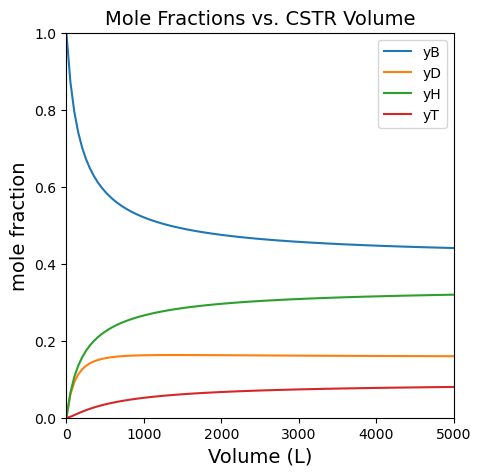

In [20]:
###########################################################################################################
# Create an array of volumes that we're interested in solving we'll go from 1 to 5000L in 100 increments  #
###########################################################################################################
V = np.linspace(1, 5000, 100)

###########################################################################################################
# We are going to be solving the system of equations for the 4 exit flowrates 100 times                   #
# We'd like to store the result of each solution, so we create an array F that has shape = (100, 4)       #
# On each pass through the loop, we'll overwrite a row of this array with the 4 solutions                 #
###########################################################################################################
F = np.zeros((len(V), 4))

###########################################################################################################
# For loop to solve system for all volumes                                                                #
###########################################################################################################
for i, vol in enumerate(V): 
    obj02y  = lambda var: P02y(var, vol) #we can use lambda functions to pass parameters to local objective function
    var0    = (FBf/2, FBf/2, FBf/2, FBf/2)
    solP02y = opt.root(obj02y, var0)
    if solP02y.success == False:
        print("Warning: opt.root() failed to converge!")
    F[i,:]  = solP02y.x

#############################################################################
# Extract effluent flowrates from F                                         #
#############################################################################
FB = F[:, 0]
FD = F[:, 1]
FH = F[:, 2]
FT = F[:, 3]
FTot = FB + FD + FH + FT

#############################################################################
# Calculate mole fractions of all species                                   #
#############################################################################
yB   = FB/FTot
yD   = FD/FTot
yH   = FH/FTot
yT   = FT/FTot

#############################################################################
# Graph mole fractions as a function of volume                              #
#############################################################################

plt.figure(figsize = (5, 5))
plt.title('Mole Fractions vs. CSTR Volume', fontsize = 14)
plt.plot(V, yB, label = 'yB')
plt.plot(V, yD, label = 'yD')
plt.plot(V, yH, label = 'yH')
plt.plot(V, yT, label = 'yT')
plt.xlim(0, max(V))
plt.ylim(0, 1)
plt.xlabel('Volume (L)', fontsize = 14)
plt.ylabel('mole fraction', fontsize = 14)
plt.legend()
plt.show()

## The significance of chemical equilibrium

As a reminder of the significance of chemical equilibrium in these systems, we see that the composition stops changing after a certain reactor size.  At this point, we've reached equilibrium.  You can see this by comparing the value of the reaction quotient to the equilibrium constant.  The system is approaching equilibrium as the reactor reaches 150000L, and if we make the reactor much larger, the extra volume won't be useful for increasing conversion since the system is basically equilibrated and no further conversion is possible.

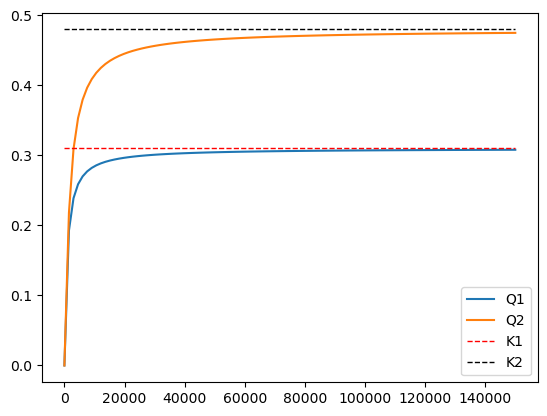

In [23]:
V = np.linspace(1, 150000, 100)
F = np.zeros((len(V), 4))

for i, vol in enumerate(V): 
    obj02y  = lambda var: P02y(var, vol)
    var0    = (FBf/2, FBf/2, FBf/2, FBf/2)
    solP02y = opt.root(obj02y, var0)
    if solP02y.success == False:
        print("Warning: opt.root() failed to converge!")
    F[i,:]  = solP02y.x

FB = F[:, 0]
FD = F[:, 1]
FH = F[:, 2]
FT = F[:, 3]
FTot = FB + FD + FH + FT
yB   = FB/FTot
yD   = FD/FTot
yH   = FH/FTot
yT   = FT/FTot

CB = yB*P/R/T #This is the ideal gas law.
CD = yD*P/R/T
CH = yH*P/R/T
CT = yT*P/R/T

Q1 = CD*CH/CB**2 #This is the right hand side of K_C = product(C_j^\nu_j) for rxn 1
Q2 = CT*CH/CD/CB #This is the right hand side of K_C = product(C_j^\nu_j) for rxn 2

plt.figure(1)
plt.plot(V, Q1, label = 'Q1')
plt.plot(V, Q2, label = 'Q2')
plt.hlines(0.31, 0, max(V), linestyle = 'dashed', linewidth = 1, color = 'red', label = 'K1')
plt.hlines(0.48, 0, max(V), linestyle = 'dashed', linewidth = 1, color = 'black', label = 'K2')
plt.legend(loc = 'lower right')
plt.show()